## THIS IS A TEST FILE TO COMPUTE THE COMPUTATIONAL ADDVANTAGE OF USING VECTORIZATION IN SOLVING AIYAGARI (1994)  
This file is not intended for solving Aiyagari 1994 but rather demonstrating the capabilities of vectorization in computing an invariant distribution over agents' states (a,z) 
#### THE STATIONARY DISTRIBUTION COMPUTAITON IS COMPUTED IN THREE WAYS: 
1. SLOW - USING NESTED FOR-LOOPS 
2. FAST - USING PARTIALLY VECTORIZED APPROACH (STILL HAS NESTED LOOPS)
3. VERY FAST - USING FULLY PARTIALLIZED VECTORIZATION   

In [ ]:
## Solving Aiyagari Model (1994)
# 08.12.2024
# Author @ Iman Taghaddosinejad (https://github.com/iman-nejad)
#**********************************************************************************
# This file computes a stationary RE-RCE using VFI + Howard Improvement
#**********************************************************************************
# This file incorporates techniques used by Hanbaek Lee in his code 
# (see https://github.com/hanbaeklee/ComputationLab). All mistakes are my own.
#**********************************************************************************
# Outline of Algorithm:
# 1. Parameterization
# 2. Guess price(s) or Aggregate(s)
# 3. Solve HH optimizaiton problem using VFI + Howard Improvement 
# 4. Compute staitonary distribution using non-stochastic itarative method
# 5. update price(s)/Aggregate(s)
# 6. Check convergence, if not repeat steps 3-6. 
#**********************************************************************************

In [3]:
## Load Packages ## 

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from quantecon.markov import tauchen

/Users/iman/opt/anaconda3/envs/envmacro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
## Set Parameters ## 

# Aiyagari (1994) 
pAlpha  = 0.36 
pBeta   = 0.96
pDelta  = 0.08 
pA      = 1 

# income process (log(z) = pRho*log(z(-1)) + eps)
pMu     = 0.0
pSigma  = 0.2
pRho    = 0.90
pNz     = 7

# wealth grid   
pNa1    = 200 # dense grid used for convergence speed testing -> implies 1,400 entries to converge 
pNa2    = 100 # finer grid for interpolation 
minGrida = 0
maxGrida = 150

In [5]:
## Helper Functions ## 

# Invariant Distribution of MC (first-order)
def fnMCss(mT, eigvlmethod=True):
    if eigvlmethod:
        _, eigvc = np.linalg.eig(mT)
        vec = eigvc[:, 0]
        vec = vec / np.sum(vec)
        return vec 
    else:
        err = 10 
        x0 = np.zeros(len(mT))
        x0[0] = 1
        while err >= 1e-12: 
            x1 = np.dot(mT, np.transpose(x0))
            err = np.max(np.abs(x1 - x0))
            x0 = np.copy(x1)
        return x0
    
# HH Obj Function
def fnHHobj(x, beta, budget, grida, Na, expvf):
    aprime = x.item() if np.ndim(x) > 0 else x 
    c = np.maximum(1e-8, budget - aprime)

    aLow = np.searchsorted(grida, aprime, side='right') - 1 
    aLow = np.maximum(0, np.minimum(Na - 2, aLow))
    aHigh = aLow + 1

    wtLow = (grida[aHigh] - aprime) / (grida[aHigh] - grida[aLow])
    wtLow = np.clip(wtLow, 0, 1)
    wtHigh = 1 - wtLow  

    expval = wtLow*expvf[aLow] + wtHigh*expvf[aHigh]

    val = -(np.log(c) + beta * expval)
    return val

# Solver (Minimizer)
def fnOptaprime(objargs, amin, amax):
    result = minimize_scalar(fnHHobj, args=objargs, 
                             bounds=[amin, amax], method='bounded', 
                             options={'xatol': 1e-12, 'maxiter': 2000})
    return result.x

# Linear (1D) Interpolation (Grid)
def fnInterp1dGrid(x, grid, Ngrid, weights=False):

    x = np.asarray(x) # allows numpy array or scalar as argument to use broadcasting  
    low = np.searchsorted(grid, x, side='right') - 1
    low = np.maximum(0, np.minimum(Ngrid - 2, low))
    high = low + 1
    if weights:
        wtLow = (grid[high] - x) / (grid[high] - grid[low])
        wtLow = np.clip(wtLow, 0, 1)
        wtHigh = 1 - wtLow
        return low, high, wtLow, wtHigh
    else:
        return low, high

In [6]:
## Grids ## 

# coarsed wealth (Maliar, Maliar, and Valli, 2010)
curvelvl = 7 
x1 = np.linspace(0, 0.5, pNa1)
x2 = np.linspace(0, 0.5, pNa2)
y1 = x1**curvelvl / np.max(x1**curvelvl)
y2 = x2**curvelvl / np.max(x2**curvelvl)
vGrida1 = minGrida + (maxGrida - minGrida) * y1 
vGrida2 = minGrida + (maxGrida - minGrida) * y2

# productivity/income 
mc = tauchen(rho=pRho, sigma=pSigma, mu=pMu, n=pNz, n_std=3)
vZ = np.exp(mc.state_values)
mTz = mc.P
vPiz = fnMCss(np.transpose(mTz), eigvlmethod=True)

In [7]:
## Initialise GE Loop ## 

# initial guess/placeholder variables 
aggK = 6 
mVF = np.transpose(np.tile(0.01 * vGrida1, (pNz, 1)))
mVFnew = np.zeros(mVF.shape)
mPolaprime1 = np.zeros((pNa1, pNz))
mPolc = np.zeros((pNa1, pNz))
currentDist = np.ones((pNa2, pNz))
currentDist = currentDist / (pNa2 * pNz) # normalize 

# parameters for loop
tolGE = 1e-8 
tolVFI = 1e-8
tolDist = 1e-8
maxGEiter = 2000
maxVFIiter = 2000 
convergedGe = False 
convergedVFI = False
wtOldK = 0.9900

In [8]:
## Main GE Loop - RE-SRCE Solver ##

#==================================================# 
# GE OUTER LOOP  
#==================================================#

aggL = np.dot(vPiz, vZ) # aggregate labour supply - exogenous (inelastic indiv. LS)
errGE = 20
iterGE = 1
while errGE >= tolGE:

    r = pAlpha * pA * (aggK / aggL)**(pAlpha - 1) - pDelta
    w = (1-pAlpha) * pA * (aggK / aggL)**(pAlpha)

    #==================================================#
    # VFI LOOP - INNER LOOP W/ Howard Improvement
    #==================================================#

    errVFI = 20
    iterVFI = 1 
    while errVFI >= tolVFI and iterVFI <= maxVFIiter:
        
        # expected VF 
        expVF = np.dot(mVF, np.transpose(mTz))

        # loop over income states 
        for iz in range(pNz):   
            
            expVFz = expVF[:, iz] # expected VF conditioned on current income state
            minwealth = minGrida 

            # loop over asset states 
            for ia in range(pNa1):
                
                #---------- VFI W/ Policy Function (Non-Accelerated) ----------#
                if iterVFI <= 30 or iterVFI % 20 == 0:
                    
                    # solve for optimal aprime (and c) - off the grid approach
                    budget = w*vZ[iz] + (1+r)*vGrida1[ia]
                    aprime = fnOptaprime(objargs=(pBeta, budget, vGrida1, pNa1, expVFz),
                                         amin=minwealth, amax=budget)
                    c = np.maximum(1e-8, budget - aprime)

                    # interpolate VF on the asset-grid corresponding to aprime 
                    aLow, aHigh, wtLow, wtHigh = fnInterp1dGrid(aprime, vGrida1, pNa1, weights=True)

                    value = wtLow*expVFz[aLow] + wtHigh*expVFz[aHigh]

                    # update VF and policy functions
                    mVFnew[ia, iz] = np.log(c) + pBeta * value 
                    mPolaprime1[ia, iz] = aprime 
                    mPolc[ia, iz] = c
                    
                    # update minimum wealth to take advtg. of monotonicity in policy rule 
                    minwealth = aprime 

                #---------- VFI W/O Policy Function (Accelerated) ----------#
                else: 
                    aprime = mPolaprime1[ia, iz]
                    c = mPolc[ia, iz]

                    # interpolate VF on the asset-grid corresponding to aprime 
                    aLow, aHigh, wtLow, wtHigh = fnInterp1dGrid(aprime, vGrida1, pNa1, weights=True)
               
                    value = wtLow*expVFz[aLow] + wtHigh*expVFz[aHigh]

                    # update VF 
                    mVFnew[ia, iz] = np.log(c) + pBeta * value 
        
        # compute error
        errVFI = np.max(np.abs(mVFnew - mVF))

        # update VF 
        mVF = np.copy(mVFnew)
        iterVFI += 1

    #--------------------------------------------------------------------# 
    # BREAK HERE - TO TEST SPEED OF CONVERGENCE FOR DISTRIBUTION LOOP !!!
    #--------------------------------------------------------------------#    
    break

    #==================================================#
    # INTERPOLATE POLICY RULE ON FINER GRID
    #==================================================#
    
    # ....

    #==================================================#
    # COMPUTE STATIONARY DISTRIBUTION
    #==================================================#

    #---------- Non-stochastic Iterative (Histogram) Method ----------#

    # ....

    #==================================================#
    # UPDATE AGGREGATE(S) AND PRICE(S)
    #==================================================#

    # ....

    #==================================================#
    # PRINT PROGRESS 
    #==================================================#

    # ....

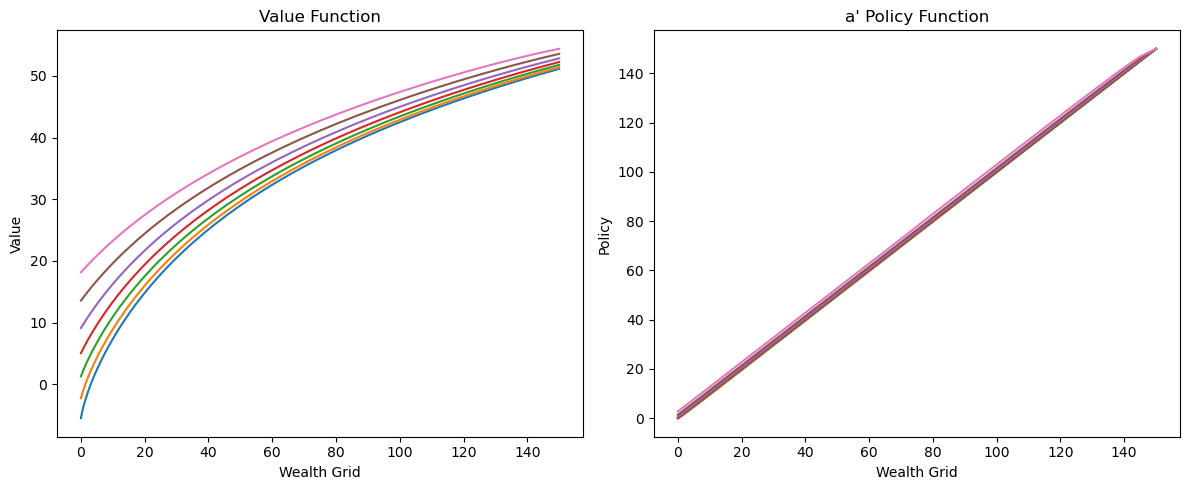

In [ ]:
# plotting value function and policy rules 

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for mVF
axs[0].plot(vGrida1, mVF)
axs[0].set_title('Value Function')
axs[0].set_xlabel('Wealth Grid')
axs[0].set_ylabel('Value')

# Plot for mPolaprime1
axs[1].plot(vGrida1, mPolaprime1)
axs[1].set_title("a' Policy Function")
axs[1].set_xlabel('Wealth Grid')
axs[1].set_ylabel('Policy')

plt.tight_layout()
plt.show()

### HERE WE DO SOME TESTING TO SEE THE RELATIVE SPEED GAIN AND ACCURACY DIFFERENCES BETWEEN VECTORIZATION AND NESTED LOOPS FOR NON-STOCHASTIC COMPUTATION OF STATIONARY DISTRIBTUION  

In [10]:
# SLOW - BUT EASY TO READ 

import time 

start_time = time.time()

currentDist = np.ones((pNa1, pNz))
currentDist = currentDist / (pNa1 * pNz) # normalize 

errDist = 10
while errDist >= 1e-6:
    newDist = np.zeros(currentDist.shape) # reset new distribution 

    for iz in range(pNz):
        for ia in range(pNa1):
            aprime = mPolaprime1[ia, iz]

            # interpolate aprime on the finer asset-grid 
            LB, UB, wtLB, wtUB = fnInterp1dGrid(aprime, vGrida1, pNa1, weights=True)

            # compute current mass over state (a,z) 
            mass = currentDist[ia, iz]

            # compute new distribution - incrementally allocate mass over LB and UB on asset-grid
            for iznext in range(pNz):
                newDist[LB, iznext] += wtLB * mass * mTz[iz, iznext]
                newDist[UB, iznext] += wtUB * mass * mTz[iz, iznext]
            
    
    # compute error
    errDist = np.max(np.abs(newDist - currentDist))

    # update distribution 
    currentDist = np.copy(newDist)

currentDist_slow = np.copy(currentDist)

end_time = time.time()

time_slow = end_time - start_time 

In [11]:
# FAST - PARTIALLY VECTORIZED 

start_time = time.time()

currentDist = np.ones((pNa1, pNz))
currentDist = currentDist / (pNa1 * pNz) # normalize 

# utilize vectorization to compute (LB,UB) over the entire aprime policy matrix
aprime = mPolaprime1
LB, UB, wtLB, wtUB = fnInterp1dGrid(aprime, vGrida1, pNa1, weights=True)   

errDist = 10 
while errDist >= 1e-6:

    # reset mass as current distribution (over all asset-productivity states (ia,iz))
    mass = currentDist

    # new distribution reset to zero - incrementally update mass over all transitions
    newDist = np.zeros(currentDist.shape)

    for iznext in range(pNz):

        # compute new mass transitioning to iznext for all (ia, iz) states at once
        newMass = mass * mTz[:, iznext] # utilize vectorization 

        # update new distribution incrementally for each current (ia, iz) state 
        for iz in range(pNz):
            for ia in range(pNa1):
                iLB, iUB, wL, wH = LB[ia, iz], UB[ia, iz], wtLB[ia, iz], wtUB[ia, iz]
                newDist[iLB, iznext] += wL * newMass[ia, iz]
                newDist[iUB, iznext] += wH * newMass[ia, iz]
    
    errDist = np.max(np.abs(newDist - currentDist))
    currentDist = np.copy(newDist)

currentDist_fast = np.copy(currentDist)

end_time = time.time() 
time_fast = end_time - start_time   

In [12]:
# FAST FAST - FULL VECTORIZATION

start_time = time.time() 

currentDist = np.ones((pNa1, pNz))
currentDist = currentDist / (pNa1 * pNz) # normalize 

# pre-compute interpolation at once 
# utilize vectorization to compute (LB,UB, wtLB, wtUB) over entire aprime policy matrix
aprime = mPolaprime1
LB, UB, wtLB, wtUB = fnInterp1dGrid(aprime, vGrida1, pNa1, weights=True)   

errDist = 10 
while errDist >= 1e-6:

    # reset mass as current distribution (over all asset-productivity states (ia,iz))
    mass = currentDist

    # new distribution reset to zero - incrementally update mass over all transitions
    newDist = np.zeros(currentDist.shape)

    for iznext in range(pNz):

        # compute new mass for ALL current states (ia, iz) transitioning to iznext
        newMass = mass * mTz[:, iznext] # utilize vectorization 

        # VECTORIZED MASS ALLOCATION USING ADV. INDEXING

        # incrementally update mass over all (ia, iz) states       
        # LB[ia,iz] gives destination asset grid index for mass from state [ia,iz]
        # wtLB[ia,iz] is interpolation weight for transitioning from ia to LB[ia,iz] (asset level only)
        # loop fixes destination (state) column to iznext in newDist
        # uses LB[ia,iz] as row indices
        # adds wtLB[ia,iz] * newMass[ia,iz] to newDist[LB[ia,iz], iznext]
        # Multiple source states [ia,iz] can contribute mass to same destination [iLB,iznext]
        # Weights depend only on asset grid distances
        # Transition probs depend only on z-states
        # Mass movement: [ia,iz] -> [LB[ia,iz], iznext] with weight wtLB[ia,iz]
        np.add.at(newDist, (LB, iznext), wtLB * newMass)
        np.add.at(newDist, (UB, iznext), wtUB * newMass)
    
    errDist = np.max(np.abs(newDist - currentDist))
    currentDist = np.copy(newDist)

currentDist_fast_fast = np.copy(currentDist)

end_time = time.time()
time_fast_fast = end_time - start_time

In [13]:
# TESTING: 

print("Computation Times (without Parallization - convergence for a 2D Numpy array of shape 200x7):")
print(f"Slow: {np.round(time_slow, 2)} seconds")
print(f"Fast: {np.round(time_fast, 2)} seconds")
print(f"Very Fast: {np.round(time_fast_fast, 2)} seconds")

maxerrtol = 1e-14
print("\n Difference between Fast & slow")
print(f"Close within {maxerrtol}: {np.allclose(currentDist_slow, currentDist_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(currentDist_slow - currentDist_fast))}")

print("\n Difference between Fast Fast & slow")
print(f"Close within {maxerrtol}: {np.allclose(currentDist_slow, currentDist_fast_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(currentDist_slow - currentDist_fast_fast))}")

print("\n Difference between Fast Fast & Fast")
print(f"Close within {maxerrtol}: {np.allclose(currentDist_fast, currentDist_fast_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(currentDist_fast - currentDist_fast_fast))}")

Computation Times (without Parallization - convergence for a 2D Numpy array of shape 200x7):
Slow: 60.29 seconds
Fast: 25.59 seconds
Very Fast: 2.84 seconds

 Difference between Fast & slow
Close within 1e-14: True
max error: 2.7755575615628914e-17

 Difference between Fast Fast & slow
Close within 1e-14: True
max error: 8.881784197001252e-16

 Difference between Fast Fast & Fast
Close within 1e-14: True
max error: 8.881784197001252e-16


In [16]:
# marginal distributions 
marginalDist_slow = np.sum(currentDist_slow, axis=1)
marginalDist_fast = np.sum(currentDist_fast, axis=1)
marginalDist_fast_fast = np.sum(currentDist_fast_fast, axis=1)

# TESTING:
print("\n Difference between Fast & slow (marginal dist)")
print(f"Close within {maxerrtol}: {np.allclose(marginalDist_slow, marginalDist_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(marginalDist_slow - marginalDist_fast))}")

print("\n Difference between Fast Fast & slow (marginal dist)")
print(f"Close within {maxerrtol}: {np.allclose(marginalDist_slow, marginalDist_fast_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(marginalDist_slow - marginalDist_fast_fast))}")

print("\n Difference between Fast Fast & Fast (marginal dist)")
print(f"Close within {maxerrtol}: {np.allclose(marginalDist_fast, marginalDist_fast_fast, atol=maxerrtol)}")
print(f"max error: {np.max(np.abs(marginalDist_fast - marginalDist_fast_fast))}")


 Difference between Fast & slow (marginal dist)
Close within 1e-14: True
max error: 1.734723475976807e-18

 Difference between Fast Fast & slow (marginal dist)
Close within 1e-14: True
max error: 2.6645352591003757e-15

 Difference between Fast Fast & Fast (marginal dist)
Close within 1e-14: True
max error: 2.6645352591003757e-15


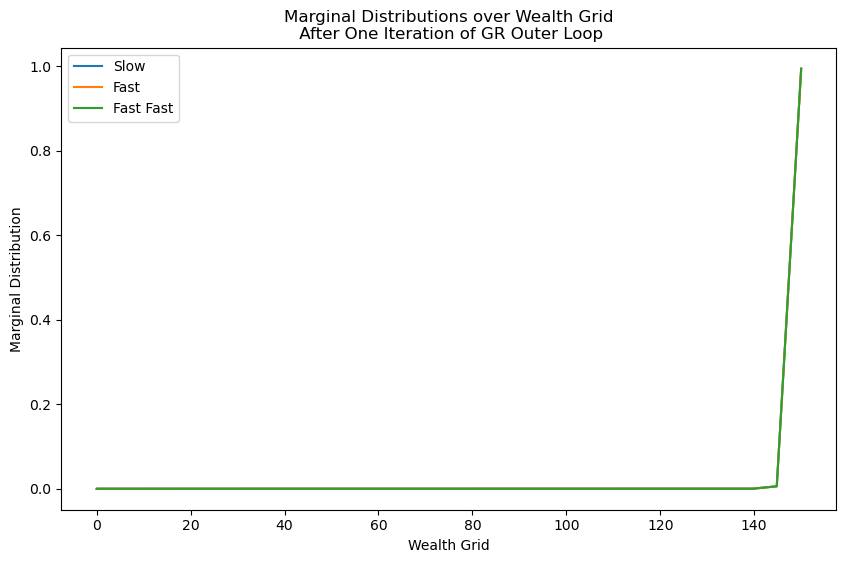

In [15]:
# plot the marginal distributions over wealth
plt.figure(figsize=(10, 6))
plt.plot(vGrida1, marginalDist_slow, label='Slow')
plt.plot(vGrida1, marginalDist_fast, label='Fast')
plt.plot(vGrida1, marginalDist_fast_fast, label='Fast Fast')
plt.title('Marginal Distributions over Wealth Grid' '\n After One Iteration of GR Outer Loop')
plt.xlabel('Wealth Grid')
plt.ylabel('Marginal Distribution')
plt.legend()
plt.show()